# Temporary Notebook for developing new Data prep Process


In [1]:
from collections import defaultdict

import pandas as pd
from shapely.geometry import Polygon


In [2]:
# Local functions and classes
from types_and_classes import *
from utilities import *
from contours import *
from debug_tools import *
#from structure_slice import *
#from structure_set import *
#from relations import *


### Global Settings

In [3]:
PRECISION = 2

In [4]:
%matplotlib inline

## Data Processing Tests

In [5]:
def embedded_spheres_example():
    slice_spacing = 0.5
    # Body structure defines slices in use
    sphere6 = make_sphere(roi_num=1, radius=3, spacing=slice_spacing)
    sphere3 = make_sphere(roi_num=2, radius=1.5, spacing=slice_spacing)
    # combine the contours
    slice_data = sphere6 + sphere3
    return slice_data

In [6]:
def multiple_spheres_example():
    slice_spacing = 0.5
    body = make_sphere(roi_num=0, radius=3, spacing=slice_spacing)
    left_sphere = make_sphere(roi_num=1, radius=2, offset_x=-2.5, offset_z=0,
                              spacing=slice_spacing)
    right_sphere = make_sphere(roi_num=1, radius=2, offset_x=2.5, offset_z=0,
                               spacing=slice_spacing)
    right_middle_sphere = make_sphere(roi_num=2, radius=1, offset_x=2.5, offset_z=0,
                                    spacing=slice_spacing)
    # combine the contours
    slice_data = left_sphere + right_sphere + right_middle_sphere + body
    return slice_data

In [7]:
def surrounded_horizontal_cylinder_example():
    slice_spacing = 1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=16, offset_z=0,
                                  spacing=slice_spacing)
    outer_cylinder = make_horizontal_cylinder(roi_num=1, radius=6, length=10,
                                              spacing=slice_spacing)
    cylinder_hole = make_horizontal_cylinder(roi_num=1, radius=5, length=8,
                                             spacing=slice_spacing)
    surrounded_cylinder = make_horizontal_cylinder(roi_num=2, radius=3, length=6,
                                                   spacing=slice_spacing)
    # combine the contours
    slice_data = body + outer_cylinder + cylinder_hole + surrounded_cylinder
    # convert contour slice data into a table of slices and structures
    return slice_data

In [8]:
def shelters_horizontal_cylinder_single_side_example():
    slice_spacing = 1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=16, offset_z=0,
                                  spacing=slice_spacing)
    outer_cylinder = make_horizontal_cylinder(roi_num=1, radius=6, length=10,
                                              spacing=slice_spacing)
    cylinder_hole = make_horizontal_cylinder(roi_num=1, radius=4, length=8,
                                             offset_x=1, offset_z=0,
                                             spacing=slice_spacing)
    surrounded_cylinder = make_horizontal_cylinder(roi_num=2, radius=3,
                                                   length=6, offset_x=1,
                                                   spacing=slice_spacing)
    # combine the contours
    slice_data = outer_cylinder + cylinder_hole + surrounded_cylinder + body
    return slice_data


In [9]:
def sphere_in_shell_example():
    slice_spacing = 1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=16, length=20, offset_z=0,
                                    spacing=slice_spacing)
    sphere12 = make_sphere(roi_num=1, radius=6, spacing=slice_spacing)
    hole10 = make_sphere(roi_num=1, radius=5, spacing=slice_spacing)
    sphere6 = make_sphere(roi_num=2, radius=3, spacing=slice_spacing)

    # combine the contours
    slice_data = body + sphere12 + hole10 + sphere6
    return slice_data

### Convert contour points to polygons and sort them by area


1. Start with list of dictionaries of contour coordinates 
    - Each dictionary contains the following items: 
        - ROI number 
            - Int ROI reference 
        - SliceIndex 
            - Float Z coordinate 
        - Coordinates 
            - List of coordinate points that form a closed polygon. 
2. Generate a contours DataFrame from the dictionary 
3. Convert each list of coordinate points to a polygon and validate it. 
4. Sort the contours DataFrame rows by  
    - ROI 
    - SliceIndex 
    - Polygon area (decreasing) 

**SliceSequence** 

- Ordered list of all slice indexes in use 
- This sequence represents only the original contour slice indexes 
- **INIT**(Series of SliceIndex) 
    1. Take the SliceIndex column from the contours DataFrame  
    1. Remove duplicates 
    1. Sort (increasing) 
    1. Set SliceIndex as the DataFrame index, but keep it as a column 
    1. Combine as a 3-column DataFrame 
        - ThisSlice:  SliceIndex,  
        - NextSlice: SliceIndex shifted by + 1,  
        - PreviousSlice: SliceIndex shifted by - 1 
    1. Add a column 'Original' and set all values to True. 
- **get_neighbors**(SliceIndex) 
    > Return: 
    > - (*NextSlice*, *PreviousSlice*) for a given SliceIndex,  
    > - *None* if the  given SliceIndex is not in the sequence 

### Create identify contours that are holes and build a graph of the contours

#### Create an graph of the contours for the ROI

**Find Contour Neighbours**

- For each Node in the ROI-specific Contour Graph, *starting with the first SliceIndex*:

1. Use the SliceSequence to obtain the Next SliceIndex.
2. Find all Contour nodes of the same hole type *(IsHole True or IsHole False)* with that Next SliceIndex.
3. If the Hulls of the two polygons overlap:
    > 1. Create an edge between the two Contour nodes
    > 2. Set a contourMatch attribute to the edge with the two Contour nodes as values.
    > 3. Set the Thickness of the edge to the difference between the two SliceIndexes.

4. For each Node in the ROI-specific ContourGraph calculate a Thickness from its edges.

**Contour Boundaries**
1. Select all Contour nodes in the ContourGraph with only one edge (degree=1)
2. For each of these nodes:
    1. Generate an interpolated boundary Contour 
        > - The contour is located half way between the boundary contour slice 
            and the neighbour slice that is not linked with an edge.
        > - set IsInterpolated to True
        > - set IsBoundary is True
        > - set IsHole matches the IsHole value of the non-interpolated Contour 
    1. Add the interpolated SliceIndex to SliceSequence:
        > - set 'Original' = False
        > - If the boundary contour SliceIndex  < the interpolated SliceIndex 
            >> - set 'PreviousSlice' = boundary contour SliceIndex, 
            >> - set NextSlice'= None
        > - Else:
            >> - set 'NextSlice'= boundary contour SliceIndex, 
            >> - set 'PreviousSlice '= None
    1. Add the interpolated contour to the contour graph .
    1. Add a ContourMatch edge between the original boundary contour and the interpolated contour.

**EnclosedRegionGraph**
- SubGraph of ContourGraph
- Identified as all nodes in ContourGraph that have a path between them
- Has a unique RegionIndex


**EnclosedRegions**
1. Create an EnclosedRegion SubGraph for each collection of nodes in the ContourGraph that are connected by a path.
2. For each EnclosedRegion:
    1. Create a new EnclosedRegionLabel.
    2. For each Contour node in the EnclosedRegion.
        1. Set Contour.RegionIndex to the EnclosedRegionLabel.
        2. Increment and Identify and label continuous contour regions.
        
**Note:** *Changes to the Contour nodes must reflect in the nodes of the ContourGraph*


**Open (External) Holes**
1. For each EnclosedRegion that is a hole:
    1. Select its boundary contours.
    2. Check whether there is a non-hole contour on the next slice that completely contains the hole boundary.
    3. If any hole boundary does not have a non-hole contour on the next slice that completely contains that hole boundary, then the hole is ***Open*** (external).
    4. If all hole boundaries have a non-hole contour on the next slice that completely contains that hole boundary, then the hole is ***Closed*** (internal).



### RegionSlices


**RegionSlice**

RegionSlice is generated by adding all contours from the same EnclosedRegion and SliceIndex, subtracting all holes.  

  - Related External holes are stored as a separate MultiPolygon attribute.
  - RegionIndex
  - SliceIndex
  - Polygon
  - ExternalHoles
  - Boundaries
  - Thickness
  - Contours
      - List of associated ContourIndexes

**INIT**

1. Receive all Contours from an EnclosedRegion with that SliceIndex.
1. Populate the Contours attribute with a list of the node labels for the supplied Contours.
1. Create a MultiPolygon by combining the Contour polygons that are not holes and not boundaries.
1. Subtract the Contour polygons that are holes from the MultiPolygon
1. Store the MultiPolygon in the Polygon attribute.
1. Create another MultiPolygon by combining all boundary contours and subtracting all hole boundaries. store this in the Boundaries attribute.
1. Create a third MultiPolygon by combining all External holes and store this in the ExternalHoles attribute.
        


**EnclosedRegionTable**

- RegionIndex
- SliceIndex
- RegionSlice


1. Create an EnclosedRegionTable
2. For each SliceIndex in each EnclosedRegion: 
    1. Create a RegionSlice using all Contours from the EnclosedRegion with that SliceIndex
    2. Calculate an approximate thickness value and set the RegionSlice Thickness attribute.
        - Thickness = sum(edge.thickness*edge.combined_area)/sum(edge.combined_area)
    3. Add the RegionSlice to the EnclosedRegionTable 
3. Place the EnclosedRegionTable and ContourGraph in a Structure


### Structures 

For each ROI: 

1. Create a ContourGraph 
2. Create an EnclosedRegionTable
3. Create a Structure 


**Structure**

*Attributes:*

  - ROI Number 
  - ID (name)
  - ContourGraph 
  - EnclosedRegionTable 
  - Physical volume 
  - External volume 
  - Hull volume 

**Calculate Structure volumes**

- **Physical** 
    1. For each node in ContourGraph: 
        1. Get the area of the polygon 
        1. Get an approximate thickness value (based on all edges connected to the node). 
            - Thickness = sum(edge.thickness*edge.combined_area)/sum(edge.combined_area) 
        1. Calculate a slice volume as area * thickness 
        1. If the node is a hole set the volume as negative 
    1. Sum the slice volumes 

- **Exterior** 
    1. For each node in ContourGraph: 
        1. Get the area of the polygon 
        1. Get an approximate thickness value (based on all edges connected to the node). 
            - Thickness = sum(edge.thickness*edge.combined_area)/sum(edge.combined_area) 
        1. Calculate a slice volume as area * thickness 
        1. If the node is an open (exterior) hole set the volume as negative 
        1. If the node is a closed (interior) hole set the volume to zero
    1. Sum the slice volumes 

- **Hull** 
    1. For each RegionSlice in EnclosedRegionTable: 
        1. Get the area of the convex hull of the MultiPolygon
        1. Calculate a slice volume as area * thickness 
        1. If the node is a hole set the volume to zero 
    1. Sum the slice volumes

 

# Apply Data Preprocess to the data

In [10]:
slice_data = sphere_in_shell_example()

In [11]:
contour_table, slice_sequence = build_contour_table(slice_data)

In [12]:
roi = 1

In [13]:
contour_graph, slice_sequence = build_contour_graph(contour_table,
                                                    slice_sequence, roi)

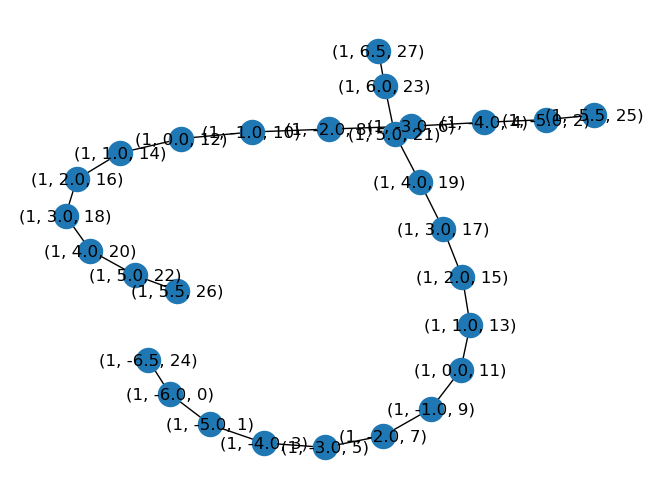

In [14]:
nx.draw(contour_graph, with_labels=True)

In [15]:
contour_lookup = build_contour_lookup(contour_graph)

In [16]:
contour_lookup

,ROI,SliceIndex,HoleType,Interpolated,Boundary,ContourIndex,RegionIndex,Label
24,1,-6.5,None,True,True,24,1A,"(1, -6.5, 24)"
0,1,-6.0,None,False,False,0,1A,"(1, -6.0, 0)"
25,1,-5.5,Closed,True,True,25,1B,"(1, -5.5, 25)"
1,1,-5.0,None,False,False,1,1A,"(1, -5.0, 1)"
2,1,-5.0,Closed,False,False,2,1B,"(1, -5.0, 2)"
3,1,-4.0,None,False,False,3,1A,"(1, -4.0, 3)"
4,1,-4.0,Closed,False,False,4,1B,"(1, -4.0, 4)"
5,1,-3.0,None,False,False,5,1A,"(1, -3.0, 5)"
6,1,-3.0,Closed,False,False,6,1B,"(1, -3.0, 6)"
7,1,-2.0,None,False,False,7,1A,"(1, -2.0, 7)"


In [17]:
enclosed_region_table = build_region_table(contour_graph, contour_lookup)

## Relation analysis process 
1. Sort structures by increasing Hull volume 
2. Starting with largest, get relations for all other structures 
    1. for each slice containing the structure:
        1. for each RegionSlice of that structure on the slice:
            1. Get a 27 bit relation with all RegionSlices of the other 
               structure that are on the same slice. 
                - MultiPolygon vs MultiPolygon
                - (BoundaryPolygon + External holes) vs MultiPolygon  
                - Convex Hull  vs MultiPolygon 
            1. Apply appropriate corrections for holes and boundaries. 
            1. If the region is a boundary, build a temporary RegionSlice from ContourGraph 
                1. If there is no matching slice for the other structure, 
                    interpolate the closest slices in the regions of the other 
                    structure. 
                1. Use SliceSequence to find nearest possible slices 
                1. If boundary slice exists in SliceSequence then no other structure 
                1. Get two nearest slice index 
                1. Find all Contours for other structure at those slice indexes 
                1. Interpolate contour points onto boundary slice 
                1. Generate new interpolated contours 
                1. Add interpolated contours to ContourGraph, but do not update SliceSequence  
                1. *Create a new RegionSlice?*
    2. Combine all relations with OR 
2. Create a relations Graph with structures as nodes and relations as edges 
2. Identify Logical relationships 

**StructureSet**

- List of Structures 
- RelationshipGraph 